In [1]:
import pandas as pds
import numpy as np
import os
import pathlib
import random
import json
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from functools import lru_cache
from typing import List, Dict, Tuple, Union, Collection

# colors = ["#E69F00", "#56B4E9", "#009E73", "#0072B2",
#           "#D55E00", "#CC79A7", "#F0E442", "gray"]

colors = ["#8ECFC9", "#FFBE7A", "#FA7F6F", "#82B0D2", "#BEB8DC", "#E7DAD2"]

In [2]:
# dataset_root = "/root/guohao/DLT-perf-model/datasets/"
dataset_root = "./datasets/"
dataset_names = [
    "RTX2080Ti_CPUALL",
    "RTX2080Ti_CPU100",
    # "RTX2080Ti_CPU80",
    "T4_CPUALL",
    "T4_CPU100",
    # "T4_CPU80",
]

dataset_name_labels = {
    "RTX2080Ti_CPUALL": "RTX2080Ti (CPU100%)",
    "RTX2080Ti_CPU100": "RTX2080Ti (CPU60%)",
    # "RTX2080Ti_CPU80": "RTX2080Ti (CPU80)",
    "T4_CPUALL": "T4 (CPU100%)",
    "T4_CPU100": "T4 (CPU60%)",
    # "T4_CPU80": "T4 (CPU80)",
}

In [3]:
models = [
    # "alexnet",
    "densenet121",
    # "densenet161",
    # "shufflenet_v2_x2",
    "googlenet",
    "efficientnet_b4",
    # "vgg11_bn",
    # "vgg16_bn",
    # "vgg19_bn",
    "convnext_large",
    # "mnasnet1_3",
    # "wide_resnet50_2",
    # "swin_b"
    # "resnet50",
    # "vgg16_bn",
    "squeezenet1_0",
    # "vit_b",
]

model_to_label = {
    "alexnet": "AlexNet",
    "densenet121": "DenseNet121",
    "densenet161": "DenseNet161",
    "shufflenet_v2_x2": "ShuffleNetV2",
    "efficientnet_b4": "EfficientNet",
    "vgg11_bn": "VGG11",
    "vgg16_bn": "VGG16",
    "vgg19_bn": "VGG19",
    "convnext_large": "ConvNext",
    "mnasnet": "MnasNet",
    "wide_resnet50_2": "WideResNet50",
    "mnasnet1_3": "MnasNet",
    "mnasnet1_0": "MnasNet",
    "swin_b": "Swin-B",
    "resnet50": "ResNet50",
    "squeezenet1_1": "SqueezeNet",
    "squeezenet1_0": "SqueezeNet",
    "vit_b": "ViT-B",
    "googlenet": "GoogleNet",

}

In [4]:
def read_model_data(_dataset_names, _model_names) -> pds.DataFrame:
    data = {}  # dataset_name -> model -> csvs
    for dataset_name in _dataset_names:
        data[dataset_name] = {}
        csvs_dir = pathlib.Path(dataset_root) / dataset_name / "train"
        csvs = os.listdir(str(csvs_dir))
        for model_name in _model_names:
            data[dataset_name][model_name] = {}
            model_csv_names = list(
                filter(lambda f: f.startswith(model_name), csvs))
            for model_csv_name in model_csv_names:
                data[dataset_name][model_name][model_csv_name] = (
                    pds.read_csv(str(csvs_dir / model_csv_name)))
    return data

In [5]:
def prepare_data_for_compare_model_performance_across_datasets():
    data = read_model_data(dataset_names, models)
    random.seed(4)

    def get_same_models(target: pds.DataFrame, csvs: Collection[pds.DataFrame]) -> List[pds.DataFrame]:
        # if values of the first row of columns:"op,dir,params,batch,h,w,input_type" are the same, then the model is the same
        # otherwise, the model is different
        # return: bool
        if len(csvs) == 0:
            return []
        columns = ["batch", "h", "w", "input_type"]
        same_models = []
        for csv in csvs:
            # print("csv.iloc[0, columns]", csv.iloc[0][columns])
            # print("target.iloc[0, columns]", target.iloc[0][columns])
            if csv.iloc[0][columns].equals(target.iloc[0][columns]):
                same_models.append(csv)
        return same_models

    same_model_data = {}  # model -> dataset -> csv
    target_dataset = "RTX2080Ti_CPUALL"
    for model_name in models:
        print(f"processing for {model_name}")
        same_model_data[model_name] = {}
        if len(data[target_dataset][model_name].keys()) == 0:
            print(f"no data for {model_name} in {target_dataset}")
            continue
        # filter out models according to space rate
        fitlered_model_csv_names = []
        for model_csv_name, csv in data[target_dataset][model_name].items():
            total_duration = csv["kduration"].sum() + csv["space"].sum()
            space_rate = csv["space"].sum() / total_duration
            if space_rate > 0.4:
                continue
            fitlered_model_csv_names.append(model_csv_name)
        if len(fitlered_model_csv_names) == 0:
            print("filter failed, use all models")
            fitlered_model_csv_names = list(
                data[target_dataset][model_name].keys())
        print(fitlered_model_csv_names)
        random.shuffle(fitlered_model_csv_names)
        temp_same_models = {}
        for target_model_csv_name in fitlered_model_csv_names:
            target_model = data[target_dataset][model_name][target_model_csv_name]
            for dataset_name in dataset_names:
                if dataset_name == target_dataset:
                    temp_same_models[dataset_name] = target_model
                    continue
                if len(data[dataset_name][model_name].keys()) == 0:
                    continue
                same_models = []
                same_models = get_same_models(
                    target_model, data[dataset_name][model_name].values())
                # print(same_models)
                if len(same_models) == 0:
                    break
                same_model = same_models[0]
                temp_same_models[dataset_name] = same_model
        # print(temp_same_models)
        assert len(temp_same_models) == len(dataset_names), print(
            model_name, f"temp_same_models keys {temp_same_models.keys()}", len(temp_same_models), len(dataset_names))
        same_model_data[model_name] = temp_same_models
    return same_model_data, target_dataset


same_model_data, target_dataset = prepare_data_for_compare_model_performance_across_datasets()

processing for densenet121
filter failed, use all models
['densenet121.54_7.csv', 'densenet121.76_7.csv', 'densenet121.73_7.csv', 'densenet121.57_7.csv', 'densenet121.88_7.csv', 'densenet121.48_7.csv', 'densenet121.91_7.csv', 'densenet121.51_7.csv', 'densenet121.60_7.csv', 'densenet121.84_7.csv', 'densenet121.42_7.csv', 'densenet121.63_7.csv', 'densenet121.78_7.csv', 'densenet121.45_7.csv', 'densenet121.39_7.csv', 'densenet121.67_7.csv']
processing for googlenet
['googlenet.108_7.csv', 'googlenet.87_7.csv']
processing for efficientnet_b4
['efficientnet_b4.58_7.csv', 'efficientnet_b4.112_7.csv']
processing for convnext_large
['convnext_large.78_7.csv', 'convnext_large.61_7.csv', 'convnext_large.41_7.csv', 'convnext_large.81_7.csv', 'convnext_large.75_7.csv', 'convnext_large.53_7.csv']
processing for squeezenet1_0
['squeezenet1_0.93_7.csv', 'squeezenet1_0.75_7.csv', 'squeezenet1_0.90_7.csv', 'squeezenet1_0.118_7.csv']


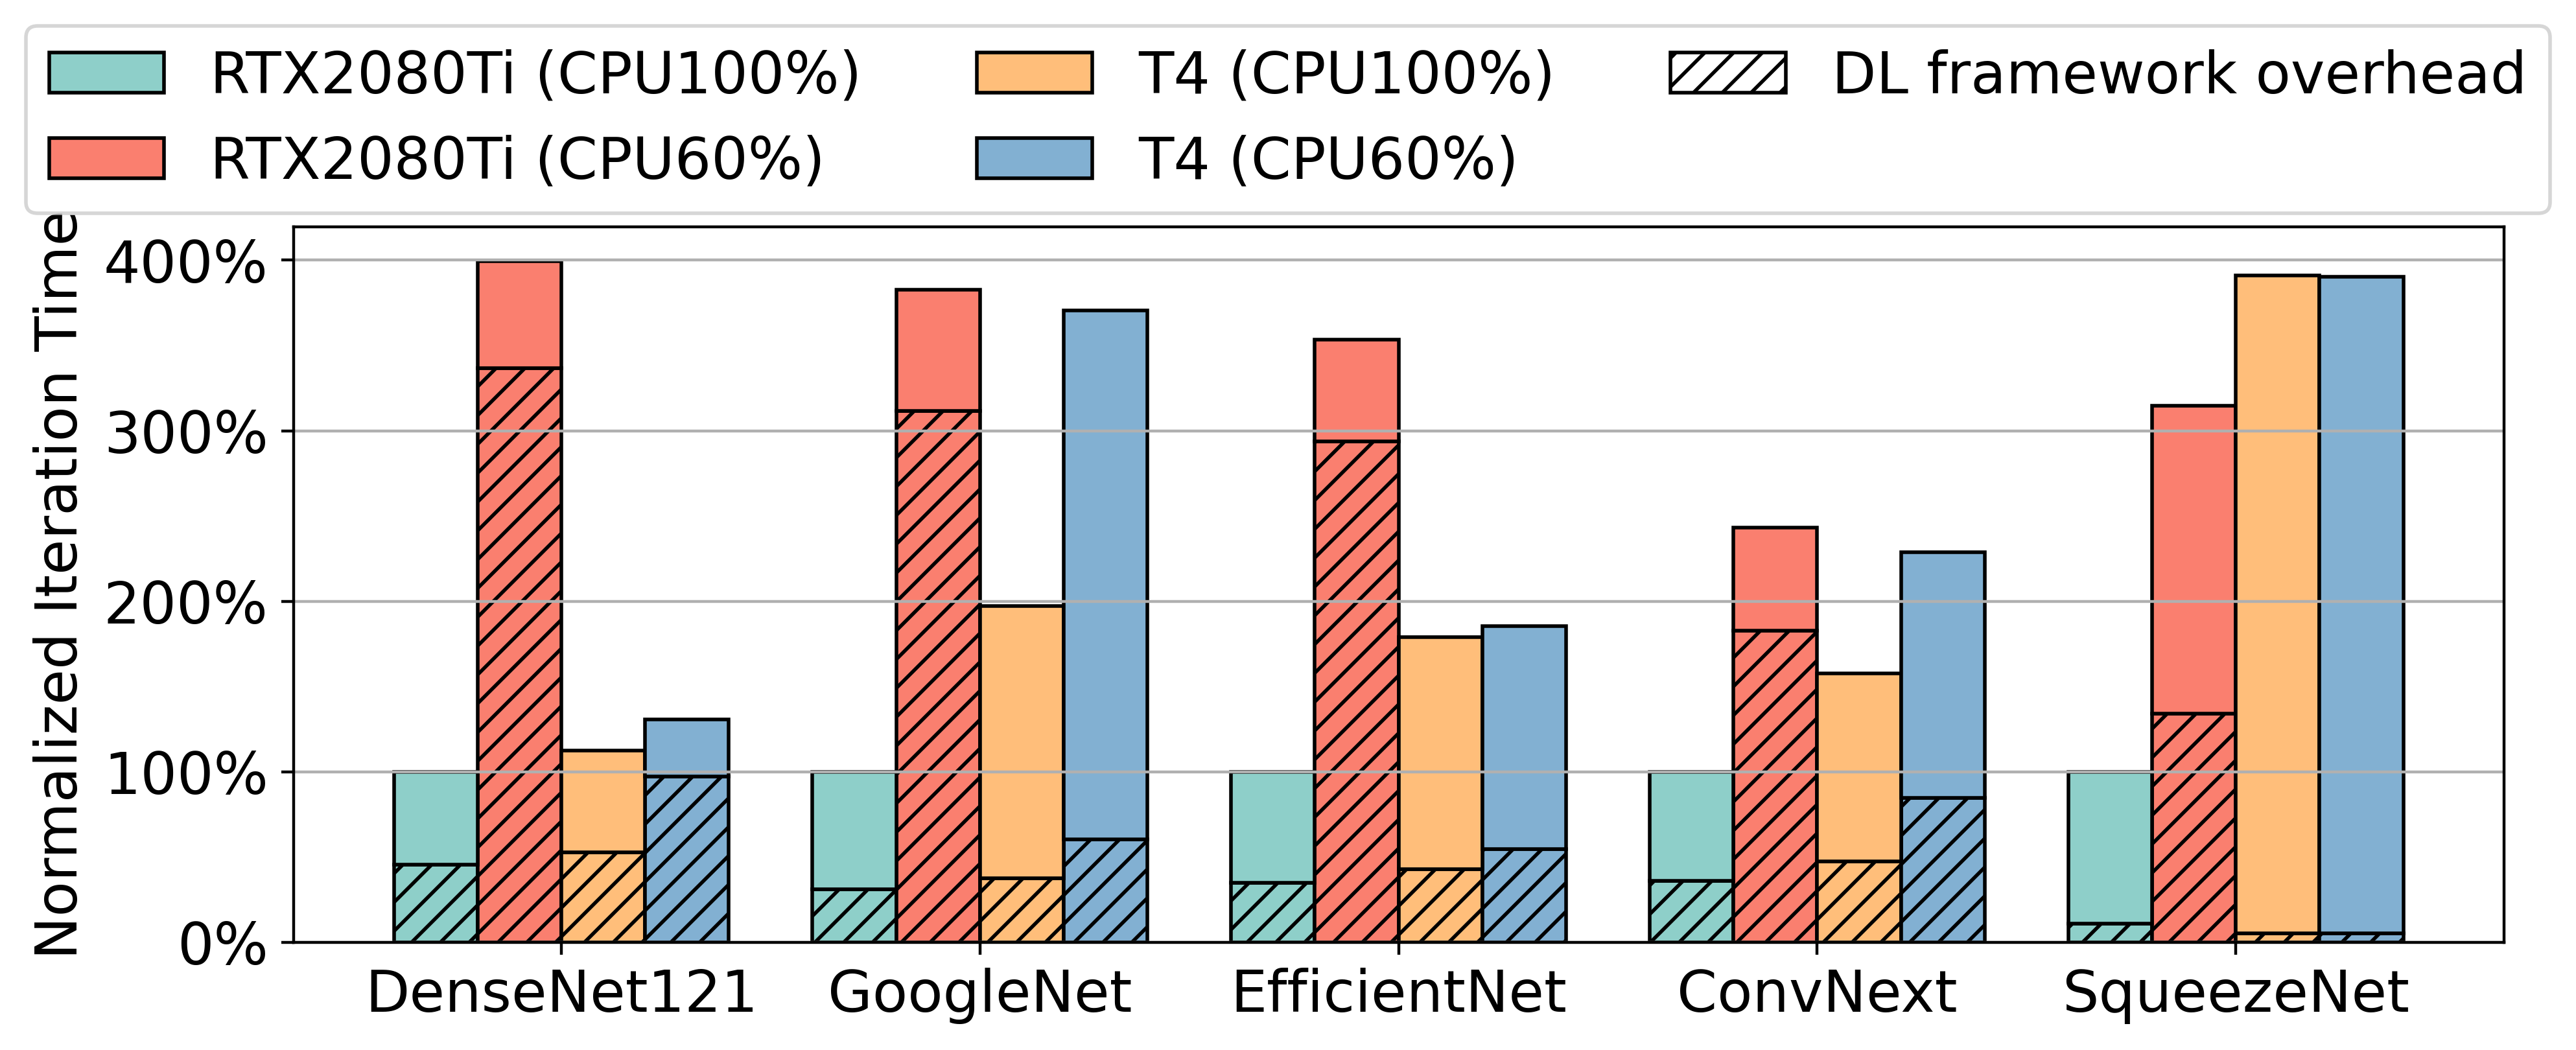

In [6]:

def draw_compare_model_performance_across_datasets(same_model_data, target_dataset):
    # print(same_model_data["alexnet"]["T4_CPU100"].keys())
    _colors = list(colors)
    _colors[0], _colors[1], _colors[2], _colors[3] = _colors[0], _colors[2], _colors[1], _colors[3]
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(figsize=(11, 4), dpi=1200)
    # draw a bar plot, each group of bars containing the same model across different datasets

    # to compare iteration time fairly, we need to normalize the iteration time by the target iteration time
    def compute_target_iteration_time(model_name: str) -> float:
        return same_model_data[model_name][target_dataset]["kduration"].sum() + same_model_data[model_name][target_dataset]["space"].sum()
    dataset_to_kdurations = {}
    for dataset_name in dataset_names:
        dataset_to_kdurations[dataset_name] = []
        for model_name in models:
            target_value = compute_target_iteration_time(model_name)
            dataset_to_kdurations[dataset_name].append(
                same_model_data[model_name][dataset_name]["kduration"].sum() / target_value)

    dataset_to_space = {}
    for dataset_name in dataset_names:
        dataset_to_space[dataset_name] = []
        for model_name in models:
            target_value = compute_target_iteration_time(model_name)
            dataset_to_space[dataset_name].append(
                same_model_data[model_name][dataset_name]["space"].sum() / target_value)

    x = np.arange(len(models))  # the label locations
    width = 0.2  # the width of the bars

    multiplier = 0
    for dataset_name, values in dataset_to_space.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, values, width, label=dataset_name,
                       edgecolor="black", color=_colors[multiplier], hatch="///")
        # ax.bar_label(rects)
        multiplier += 1

    multiplier = 0
    for dataset_name, values in dataset_to_kdurations.items():
        offset = width * multiplier
        ax.bar(x + offset, values, width, label=dataset_name, edgecolor="black",
               color=_colors[multiplier], bottom=dataset_to_space[dataset_name])
        # ax.bar_label(rects)
        multiplier += 1

    legend_artists = []
    for i, dataset_name in enumerate(dataset_names):
        handle = Patch(
            facecolor=_colors[i],
            edgecolor="black",
            label=dataset_name_labels[dataset_name],
        )
        legend_artists.append(handle)
    handle = Patch(
        facecolor="white",
        edgecolor="black",
        label="DL framework overhead",
        hatch="///"
    )
    legend_artists.append(handle)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Normalized Iteration Time')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=0))
    labels = [model_to_label[model_name] for model_name in models]
    ax.set_xticks(x + 3*width/2, labels)
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.yaxis.grid(True)
    # legend with two rows, three cols
    ax.legend(handles=legend_artists, bbox_to_anchor=(
        0.45, 1.15), loc='center', ncol=3, borderaxespad=0)
    fig.subplots_adjust(top=0.8)
    # ax.legend(handles=legend_artists, bbox_to_anchor=(1.01, 1), borderaxespad=0)
    # ax.set_ylim(0, 1.2)
    plt.show()
    fig.savefig("imgs/compare_model_performance_across_datasets.png",
                dpi=1200, format="png", bbox_inches="tight")
    fig.savefig("imgs/compare_model_performance_across_datasets.pdf",
                dpi=1200, format="pdf", bbox_inches="tight")
    mpl.rcParams.update({'font.size': original_fontsize})


draw_compare_model_performance_across_datasets(same_model_data, target_dataset)

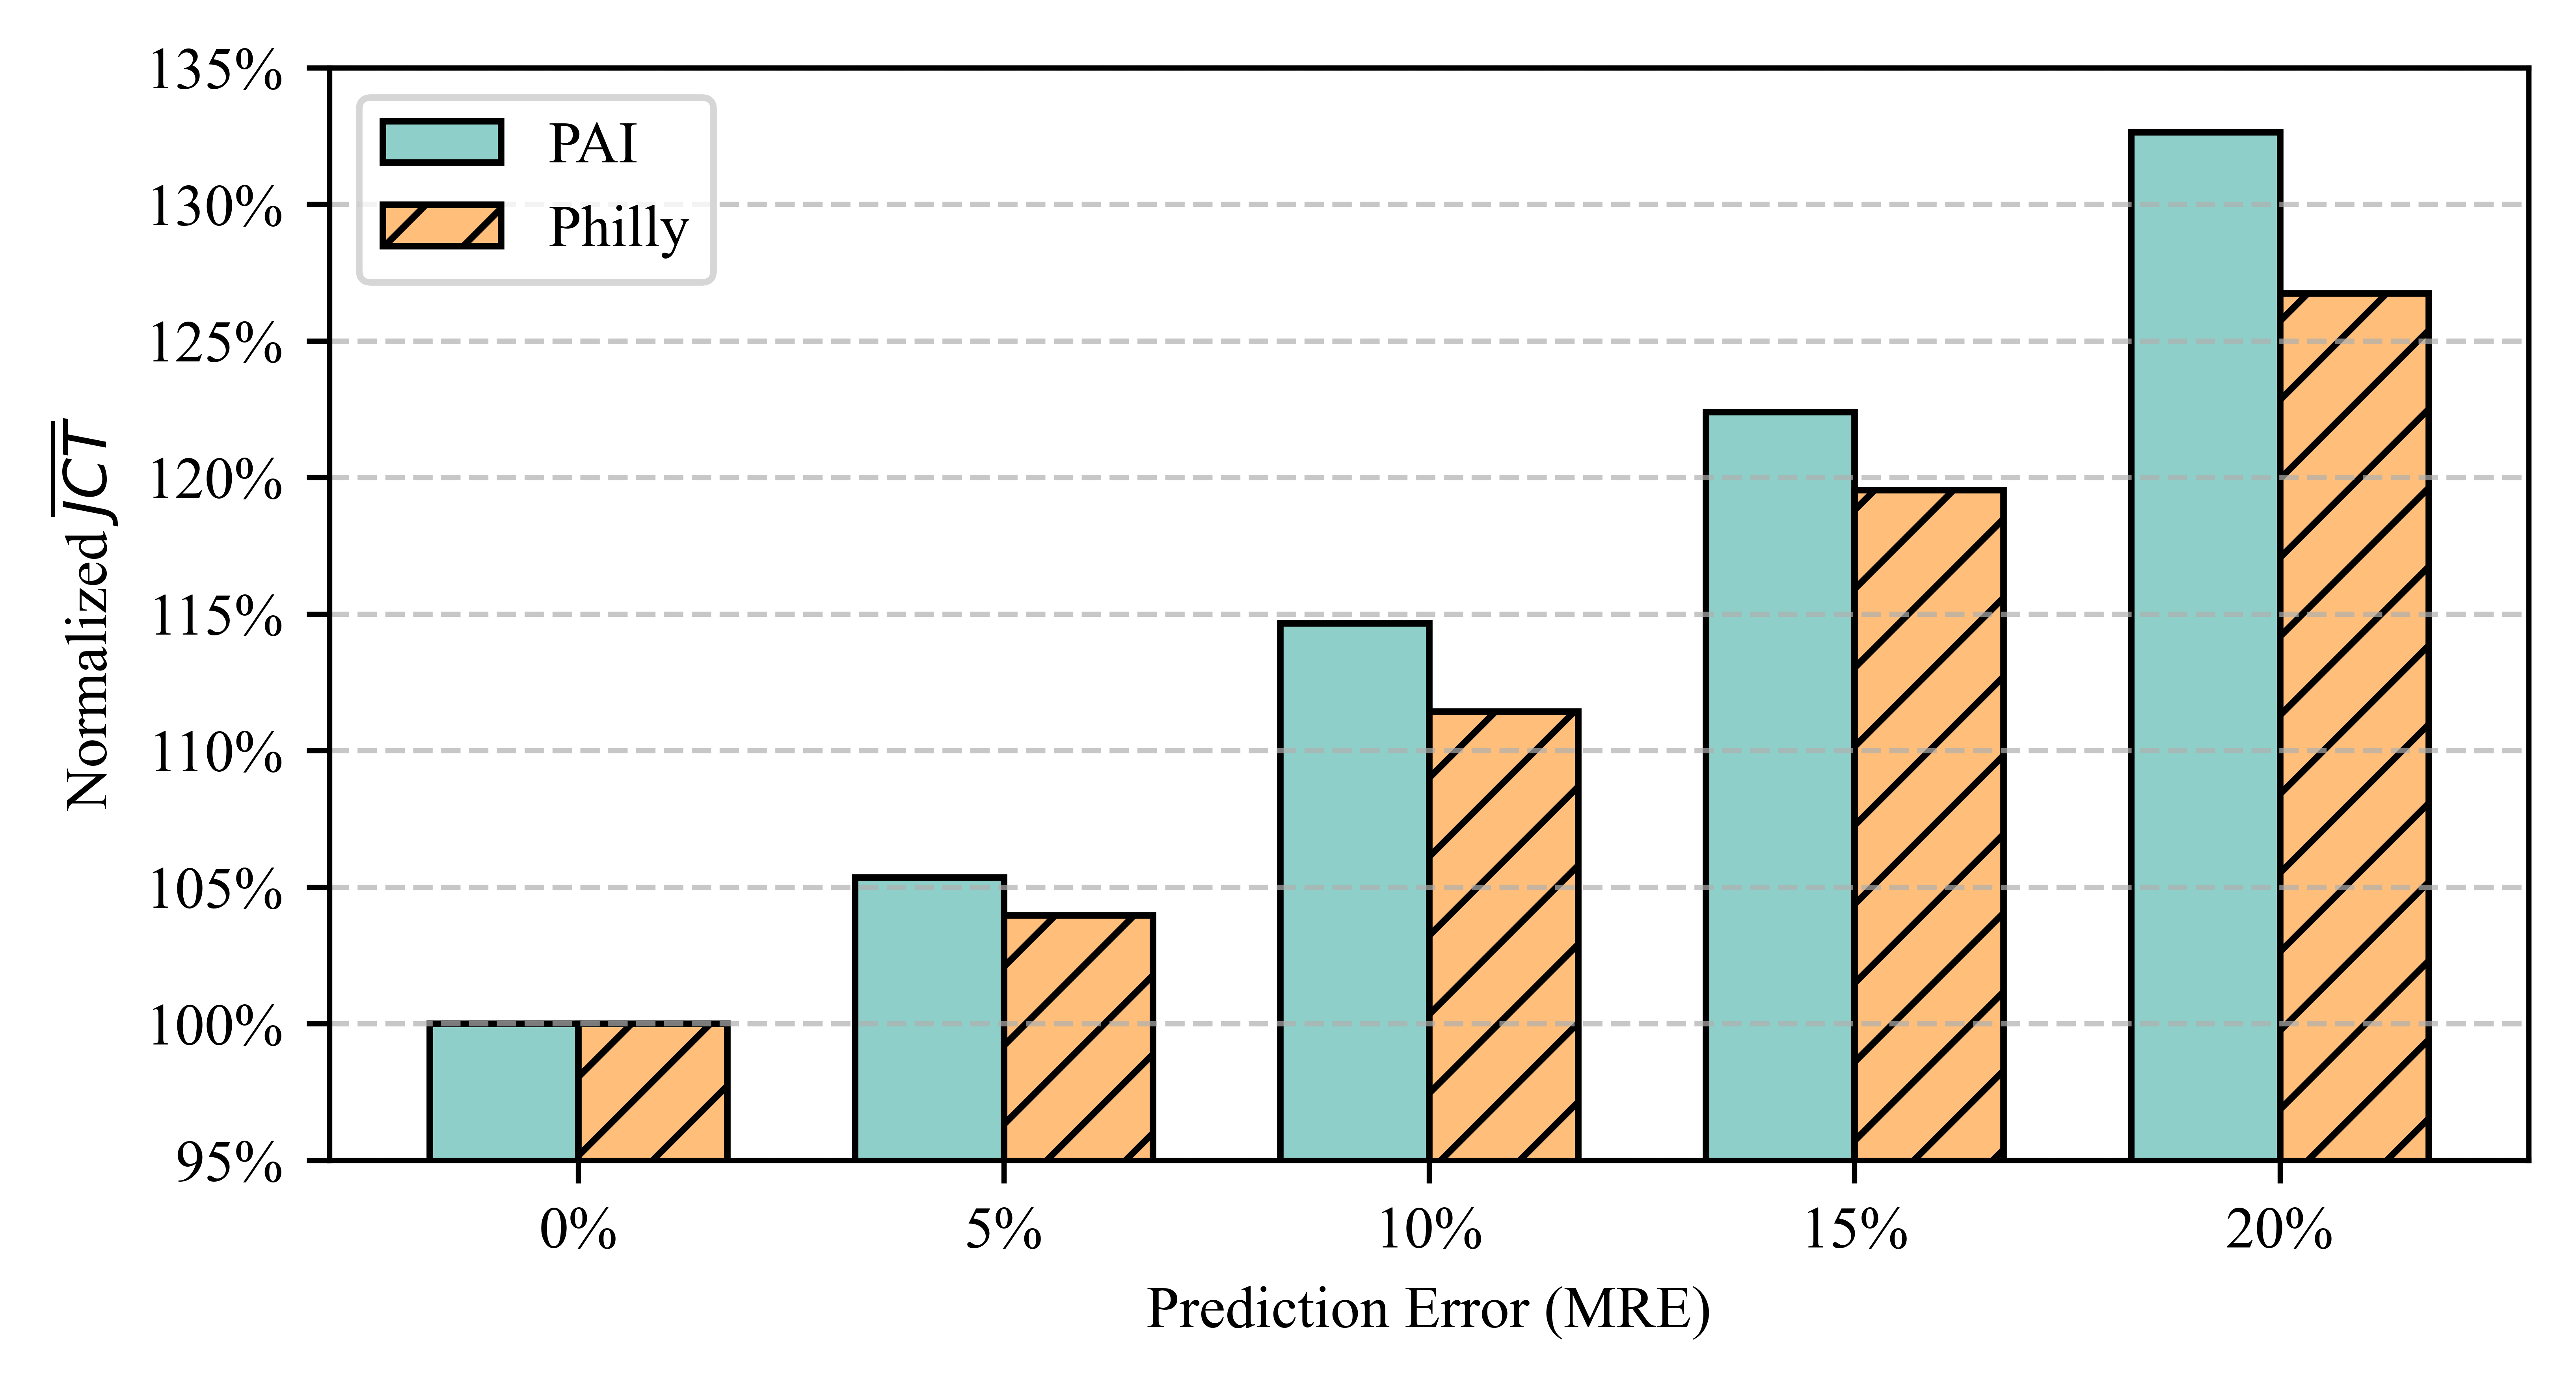

In [8]:
def draw_pred_acc():
    with open("./plots/priority_report.json", "r") as f:
        data = json.load(f)
    # Extracting the keys and values for 'ali' and 'phi'
    data = data['JCT']
    ali_data = data['ali']
    phi_data = data['phi']
    keys = list(ali_data.keys())
    keys.remove("FIFO")

    # Extracting the numerical values from the keys and converting to percentage
    # labels = [f"{100-int(key.split('_')[1])}%" if key != 'FIFO' else 'LAS' for key in keys]
    # labels = [0, 5, 10, 15, 20]
    labels = ["0%", "5%", "10%", "15%", "20%"]
    # Normalizing the data for 'ali' and 'phi'
    ali_values = [ali_data[key] / min(ali_data.values()) for key in keys]
    phi_values = [phi_data[key] / min(phi_data.values()) for key in keys]

    mpl.rcParams.update({'font.size': 9})
    mpl.rcParams['font.family'] = 'Times New Roman'
    # plt.rcParams['font.family'] = 'Times New Roman'
    # mpl.rcParams.update('font.family':'serif', 'font.serif':['Times New Roman'])
    # Setting up the figure and axes
    fig, ax = plt.subplots(figsize=(6, 3), dpi=1200)
    original_fontsize = mpl.rcParams["font.size"]
    width = 0.35
    x = range(len(keys))

    # Plotting 'ali' data

    rects1 = ax.bar(x, ali_values, width, hatch='',
                    color=colors[0], edgecolor='black', label='ali')

    # Plotting 'phi' data
    rects2 = ax.bar([i + width for i in x], phi_values, width, hatch="//", color=colors[1], edgecolor='black',
                    label='phi')

    # Setting up the x-axis and labels
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(labels)
    ax.set_xlabel("Prediction Error (MRE)")

    # Setting up the y-axis
    ax.set_ylabel('Normalized $\overline{JCT}$')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=0))
    ax.set_ylim(0.95, 1.35)

    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.legend(["PAI", "Philly"], loc='upper left')

    fig.savefig(f'imgs/pred_acc_JCT.pdf', dpi=1200,
                format='pdf', bbox_inches='tight')
    mpl.rcParams.update({'font.size': original_fontsize})


draw_pred_acc()